In [1]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
#import wfdb
from scipy.io import loadmat  

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
from SpectralMixture import SpectralMixture, initialize_from_emp_spec, SpectralMixtureComponent
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses
from bnqdflow.effect_size_measures import MAE

discontinuity: 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ve

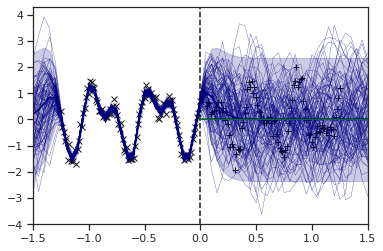

Bayes factors: [[110.25610194]]
Average causal effects: [[[7.88612368e-01 9.24890963e-01 1.00784840e+00 1.04466938e+00
   1.04404924e+00 1.01472988e+00 9.64704308e-01 9.00845364e-01
   8.28794075e-01 7.52998338e-01 6.76831067e-01 6.02743009e-01
   5.32423005e-01 4.66950136e-01 4.06929732e-01 3.52609964e-01
   3.03978627e-01 2.60841344e-01 2.22883213e-01 1.89716281e-01
   1.60915193e-01 1.36043223e-01 1.14670660e-01 9.63872003e-02
   8.08097760e-02 6.75869577e-02 5.64008491e-02 4.69672077e-02
   3.90343497e-02 3.23812699e-02 2.68152961e-02 2.21695136e-02
   1.83001251e-02 1.50838626e-02 1.24155264e-02 1.02056962e-02
   8.37864213e-03 6.87044140e-03 5.62730220e-03 4.60408502e-03
   3.76300913e-03 3.07252889e-03 2.50636362e-03 2.04266444e-03
   1.66330232e-03 1.35326214e-03 1.10012921e-03 8.93655399e-04
   7.25393927e-04 5.88392715e-04 4.76937668e-04 3.86338269e-04
   3.12748928e-04 2.53020443e-04 2.04576745e-04 1.65312807e-04
   1.33510248e-04 1.07767656e-04 8.69431731e-05 7.01072401e-05

In [8]:
# Triple cosine Time series fit + spectra 
# ---------------------------

np.random.seed(1)

# Create synthetic data
N           = 200
sigma       = .2
b           = 0.
x           = np.linspace(-1.25, 1.25, N)
fs          = 200/2.4
x1, x2      = x[x<=b], x[x>b]

xlim        = [-1.5,1.5]
xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
# max_freq    = 4 * 2 * np.pi
# max_length  = 10.


# Plotting parameters
padding           = 0.1
n_seeds     = 1

# Iterate over discontinuity sizes
discontinuity_sizes   = np.arange(2, 9, step=2)
discontinuity_sizes   = np.arange(4, 5, step=1) # double cosine
#discontinuity_sizes    = np.arange(0,9, step=1) # 5 cosines

d = 0
discontinuity_funcs   = [('Shifting',t.shifting_discontinuity_mean_function, 2,[[12, 25],[(12+d), (25+d)]],  (-1.7,2.) )]#,
                         # ('triple trigonometry', t.triple_trigonometry, 3, [[5, 17 , 28 ], [(5+d), (17 + d) , (28 + d)]], (-4.7,5.2)  )]
bayes_factors  = np.zeros((discontinuity_sizes.shape[0], n_seeds))
effect_sizes, true_effect =  [np.zeros((discontinuity_sizes.shape[0], n_seeds, int(N/2))) for i in range(2)]
plot_regression=True
samples = []
# start
for n, (name, func, Q, true_freqs, ylim) in enumerate(discontinuity_funcs):
    for i, d in enumerate(discontinuity_sizes):                
        print(f'discontinuity: {d}')
        true_freqs[1] = true_freqs[0] + d
        for s in range(n_seeds): # repeated trials with varying gaussian noise
                
            ## Generate data with noise
            f = func(x,d)
            y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
            y1, y2            = y[x <= b], y[x > b]

            fs = 40
            dummy_kernel    = Matern52() #Linear()
            a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], dummy_kernel, b, share_params=False)
            
#             # Determine for each model the number of components
#             min_Q, max_Q   = 1, 4
#             Q_continuous   = t.find_optimal_Q(x, y, a.continuous_data, min_Q, max_Q, fs) # To do: find a way to specify the prior outside of the toolbox..
#             Q_control      = t.find_optimal_Q(x1, y1, a.discontinuous_data[0], min_Q, max_Q, fs)
#             Q_intervention = t.find_optimal_Q(x2, y2, a.discontinuous_data[1], min_Q, max_Q, fs) 
#             print(Q_continuous, Q_control, Q_intervention)

#             sm_continuous   = SpectralMixture(Q_continuous,   x=x.flatten(),  y=y.flatten(),  fs=fs)
#             sm_control      = SpectralMixture(Q_control,      x=x1.flatten(), y=y1.flatten(), fs=fs)
#             sm_intervention = SpectralMixture(Q_intervention, x=x2.flatten(), y=y2.flatten(), fs=fs)
            
#             # Assign priors to kernels
#             kernels = [sm_continuous, sm_control, sm_intervention]
#             for kernel in kernels:
#                 for k in kernel.kernels:
#                     if isinstance(k, SpectralMixtureComponent):
#                         k.lengthscale.prior = tfd.Gamma(f64(8.), f64(.6))         
#                         k.mixture_weight.prior = tfd.Gamma(f64(1.), f64(1.))           
            
#             a.continuous_model.models[0].kernel    = sm_continuous 
#             a.discontinuous_model.models[0].kernel = sm_control
#             a.discontinuous_model.models[1].kernel = sm_intervention
            a.train(verbose=False)
            
            # Save results
            log_bayes_factor = a.log_bayes_factor(verbose=True)
            bayes_factors[i,s] = log_bayes_factor.numpy()
            causal_effects, average_es, sum_es = a.get_effect_size(MAE())
            effect_sizes[i,s] = causal_effects.flatten()
            
       
            x_int = np.linspace(0, 1.25, int(N/2))
            no_disc = func(x_int, 0)
            disc = func(x_int, d)
            true_effect[i,s] = np.absolute(np.array(disc) - np.array(no_disc)).flatten()
#             for obs in x:
#                 true_effect += func(obs, d)

#             np.save('data', np.array([x,y,b]))

#             np.save('causal_effects', causal_effects)
#             np.save('bayes_factor', bayes_factors)
#             np.save('Q_values', np.array([Q_continuous, Q_control, Q_intervention]))
                
            # Plot regression
            if plot_regression:
                #f_samples_list = t.plot_posterior_model_spectrum(a, padding=padding, max_x = 40,  true_freqs=true_freqs,ylim=ylim, scalar = 1,num_f_samples=100)
                f_samples_list = a.discontinuous_model.plot_regression(padding=padding, num_f_samples=100)
                #plt.savefig('samplesSyntheticCosDiverging.pdf',dpi=400)
                plt.show()

                f_samples = []
                for sample in f_samples_list:
                    f_samples.append(sample.numpy())
                samples.append(np.array(f_samples))

np.save('samples_disc', samples)
# np.save('effect_sizes', effect_sizes)                
# np.save('true_effect', true_effect) 
# np.save('bayes_factors', bayes_factors)

print(f'Bayes factors: {bayes_factors}')
print(f'Average causal effects: {effect_sizes}')

In [3]:
# # Tripel cosine spectra
# np.random.seed(1)

# # Create synthetic data
# N           = 100
# sigma       = .5
# b           = 0.
# x           = np.linspace(-1.25, 1.25, N)
# x1, x2      = x[x<=b], x[x>b]

# xlim        = [-1.5,1.5]
# xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
# max_freq    = 4 * 2 * np.pi
# max_length  = 10.


# # Plotting parameters
# padding           = 0.1

# # Iterate over discontinuity sizes
# discontinuity_sizes   = np.arange(2, 9, step=2)
# d = 0
# discontinuity_funcs   = [('Shifting',t.shifting_discontinuity_mean_function, 2,[[12, 25],[(12+d), (25+d)]],  (-1.7,2.) ),
#                           ('triple trigonometry', t.triple_trigonometry, 3, [[5, 17 , 28 ], [(5+d), (17 + d) , (28 + d)]], (-4.7,5.2)  )]
# bayes_factors, effect_sizes = [np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0],n_seeds)) for i in range(2)]

# n_seeds     = 1

#     # Continuous spectral GMM    
# fig, axes = plt.subplots(3,4,sharex=False,sharey=False,figsize=(9*4,12))
# cols = [f'$d$ = {d}'.format(d) for d in discontinuity_sizes]
# rows = ['{}'.format(row) for row in ['Continuous','Control', 'Intervention']]
# pad = 5 # in points

# for ax, col in zip(axes[0], cols):
#     ax.annotate(col, xy=(0.5, 1.02), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 fontsize=35, ha='center', va='baseline')
   
# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 fontsize=24, ha='right', va='center')
    
# # start
# for n, (name, func, Q, true_freqs, ylim) in enumerate(discontinuity_funcs):
#     for i, d in enumerate(discontinuity_sizes):                
#         print(f'discontinuity: {d}')
#         true_freqs[1] = true_freqs[0] + d
#         for s in range(n_seeds): # repeated trials with varying gaussian noise
                
#             # Obtain data with discontinuity
#             f = func(x,d)
#             y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
#             y1, y2            = y[x <= b], y[x > b]

#             # Create spectral mixture kernel
#             #Q                 = t.find_optimal_Q(x.reshape(N,1), y, min_Q=1, max_Q=7, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
#             sm                = SpectralMixture(Q=Q, max_length=max_length, max_freq=max_freq)

#             # Run analysis Spectral Mixture
#             a = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b, share_params=False)
#             a.train(verbose=False)

#             log_bayes_factor = a.log_bayes_factor(verbose=False)
#             bayes_factors[n,i,s] = log_bayes_factor.numpy()
    
#             # Save results
#             causal_effects, average_es, sum_es = a.get_effect_size(MAE())
#             effect_sizes[n,i,s] = average_es
            
#             t.plot_model_spectra(a,Q,d,axes[:,i] ,index=i, padding=padding, max_x = 38, 
#                                     true_freqs=true_freqs,ylim=ylim, scalar = 1)
                
# fig.tight_layout()
# fig.subplots_adjust(top=0.9)    
# handles, labels = axes[1,1].get_legend_handles_labels()
# plt.figlegend(handles, labels, loc='lower center', ncol=1, fontsize=20, fancybox=True,bbox_to_anchor=(0.55, -0.01))
# fig.subplots_adjust(bottom=0.1)   
# # plt.savefig('shifting_spectra_08.pdf',dpi=100)

# plt.show()
# print(f'Bayes factors: {bayes_factors}')
# print(f'Average causal effects: {effect_sizes}')

In [4]:
# Double cosine Time series fit + spectra 
# analyses shown in paper.
# ---------------------------

np.random.seed(1)

# Create synthetic data
N           = 100
sigma       = .2
b           = 0.
x           = np.linspace(-1.25, 1.25, N)
x1, x2      = x[x<=b], x[x>b]
n_seeds     = 1

xlim        = [-1.5,1.5]
xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
max_freq    = 4 * 2 * np.pi
max_length  = 10.

# Kernels (not used)
colours_prior   = ['#1a1835', '#15464e', '#2b6f39', '#757b33', '#c17a70', '#d490c6', '#c3c1f2', '#cfebef']
#pt.plot_kernel_spectrum(Q, sm, max_x=max_freq*1.2, title="Initial GMM spectral density", colours=colours_prior)
#plt.show()

# Plotting parameters
padding           = 0.1
ylim              = (-1.7,2.)#(-4.7,5.2)#(-2.5,2.3)

# Iterate over discontinuity sizes
discontinuity_sizes   = np.arange(2, 9, step=2)
discontinuity_sizes   = np.arange(4, 5, step=2)

discontinuity_funcs   = [('Shifting',t.shifting_discontinuity_mean_function)]
                         #,('Amplitude',t.weight_discontinuity_mean_function)]
                         #, ('triple trigonometry', t.triple_trigonometry)]
bayes_factors, effect_sizes = [np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0],n_seeds)) for i in range(3)]

    
    
# start
for i, d in enumerate(discontinuity_sizes):
      for n, (name, func) in enumerate(discontinuity_funcs):
            for s in range(n_seeds): # repeated trials with different gaussian noise
                np.random.seed(s+4) # s+4: shifting s+6:diverging
                
                # Obtain data with discontinuity
                f = func(x,d)
                y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
                
                
                y1, y2            = y[x <= b], y[x > b]
                

                true_freqs_shifting = [[12 , 25 ], [(12 + d) , (25 + d)] ]
                true_freqs_diverging= [[12 , 25 ], [(12 - d) , (25 + d)] ]
                if name == 'Shifting':
                      true_freqs = true_freqs_shifting
                else:
                      true_freqs = true_freqs_diverging
                #true_freqs = None

                # Create spectral mixture kernel
                Q                 = 2 #t.find_optimal_Q(x.reshape(N,1), y, min_Q=1, max_Q=7, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
                sm                = SpectralMixture(Q=Q, max_length=max_length, max_freq=max_freq)

                # Run analysis Spectral Mixture
                a = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b, share_params=False)
                a.train(verbose=True)
                

                log_bayes_factor = a.log_bayes_factor(verbose=False)
                bayes_factors[n,i,s] = log_bayes_factor.numpy()

                t.plot_posterior_model_spectrum(a, Q, padding=padding, max_x = 40, 
                                                 true_freqs=true_freqs,ylim=ylim, scalar = 1, num_f_samples=3)
                #plt.savefig('samplesSyntheticCosDiverging.pdf',dpi=400)
                plt.show()

        

                causal_effects, average_es, sum_es = a.get_effect_size(MAE())
                effect_sizes[n,i,s] = average_es
print(f'Log Bayes factors: {bayes_factors}')
print(f'Average causal effects: {effect_sizes}')

ValueError: too many values to unpack (expected 2)

In [ ]:
# # Save data of model
# data = a.continuous_model.data_list
# x, y = data[0]
# x, y = x.numpy(), y.numpy()
# print(x.shape, y.shape)
# data= np.array([x,y,b])
# np.save('x', x)
# np.save('y', y)
# # Save continuous mean, var, samples


In [ ]:
# # Plot of only the spectra
# np.random.seed(1)

# # Create synthetic data
# N           = 100
# sigma       = .2
# b           = 0.
# x           = np.linspace(-1.25, 1.25, N)
# x1, x2      = x[x<=b], x[x>b]
# n_seeds     = 1

# xlim        = [-1.5,1.5]
# xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
# max_freq    = 4 * 2 * np.pi
# max_length  = 10.

# # Kernels (not used)
# colours_prior   = ['#1a1835', '#15464e', '#2b6f39', '#757b33', '#c17a70', '#d490c6', '#c3c1f2', '#cfebef']
# #t.plot_kernel_spectrum(Q, sm, max_x=max_freq*1.2, title="Initial GMM spectral density", colours=colours_prior)
# #plt.show()

# # Plotting parameters
# padding           = 0.1
# ylim              = (-1.7,2.)#(-4.7,5.2)#(-2.5,2.3)

# # Iterate over discontinuity sizes
# discontinuity_sizes   = np.arange(2, 9, step=2)

# discontinuity_funcs   = [('Shifting',t.shifting_discontinuity_mean_function)]
#                          #,('Amplitude',t.weight_discontinuity_mean_function)]
#                          #, ('triple trigonometry', t.triple_trigonometry)]
# bayes_factors, effect_sizes = [np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0],n_seeds)) for i in range(3)]

    
#     # Continuous spectral GMM    
# fig, axes = plt.subplots(3,4,sharex=False,sharey=False,figsize=(9*4,12))
# cols = [f'$d$ = {d}'.format(d) for d in discontinuity_sizes]
# rows = ['{}'.format(row) for row in ['Continuous','Control', 'Intervention']]
# pad = 5 # in points

# for ax, col in zip(axes[0], cols):
#     ax.annotate(col, xy=(0.5, 1.02), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 fontsize=35, ha='center', va='baseline')
   
# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 fontsize=24, ha='right', va='center')
    
# # start
# for i, d in enumerate(discontinuity_sizes):
#       for n, (name, func) in enumerate(discontinuity_funcs):
#             for s in range(n_seeds): # repeated trials with different gaussian noise
#                 np.random.seed(s+4) # s+4: shifting s+6:diverging
                
#                 # Obtain data with discontinuity
#                 f = func(x,d)
#                 y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
#                 y1, y2            = y[x <= b], y[x > b]

#                 true_freqs_shifting = [[12 , 25 ], [(12 + d) , (25 + d)] ]
#                 true_freqs_diverging= [[12 , 25 ], [(12 - d) , (25 + d)] ]
#                 if name == 'Shifting':
#                       true_freqs = true_freqs_shifting
#                 else:
#                       true_freqs = true_freqs_diverging
#                 #true_freqs = None

#                 # Create spectral mixture kernel
#                 Q                 = 2 #t.find_optimal_Q(x.reshape(N,1), y, min_Q=1, max_Q=7, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
#                 sm                = SpectralMixture(Q=Q, max_length=max_length, max_freq=max_freq)

#                 # Run analysis Spectral Mixture
#                 a = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b, share_params=False)
#                 a.train(verbose=False)
                

#                 log_bayes_factor = a.log_bayes_factor(verbose=False)
#                 bayes_factors[n,i,s] = log_bayes_factor.numpy()

#                 t.plot_model_spectra(a,Q,d,axes[:,i] ,index=i, padding=padding, max_x = 38, 
#                                         true_freqs=true_freqs,ylim=ylim, scalar = 1)
            

#                 causal_effects, average_es, sum_es = a.get_effect_size(MAE())
#                 effect_sizes[n,i,s] = average_es
# fig.tight_layout()
# fig.subplots_adjust(top=0.9)    
# handles, labels = axes[1,1].get_legend_handles_labels()
# plt.figlegend(handles, labels, loc='lower center', ncol=1, fontsize=20, fancybox=True,bbox_to_anchor=(0.55, -0.01))
# fig.subplots_adjust(bottom=0.1)   
# # plt.savefig('shifting_spectra_08.pdf',dpi=100)
# # #plt.savefig('diverging_spectra_08-2.pdf',dpi=100)

# plt.show()
# print(f'Bayes factors: {bayes_factors}')
# print(f'Average causal effects: {effect_sizes}')

In [ ]:
# Bar plot of Effect sizes and Bayes factor
#------------------------

# Set plotting parameters
plt.rc('axes', titlesize=26)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=28)  # fontsize of the figure title
# subfigure title: 24
cs = 12
lw = 3
# Initlaize sibfigure
colors=['#79b895' ,'#374e70', 'purple']
#colors=['green', 'blue']
colors = ['#5e75a1', '#2c9553', 'purple']
sns.set(style="ticks")
fig, ax = plt.subplots(1, 2,figsize=(26,8),sharex=True)

# Bayes factor plot
print(bayes_factors.shape,' : (discontinuity function, discontinuity size, seeds)')

for i, (name, function, Q, true_freqs, ylim) in enumerate(discontinuity_funcs):
    disc_mean, disc_std = [np.zeros((discontinuity_sizes.shape[0])) for i in range(2)]
    for j, d in enumerate(discontinuity_sizes):
        disc_mean[j] = np.mean(bayes_factors[i,j,:],axis=0)
        disc_std[j] = np.std(bayes_factors[i,j,:], axis=0)
    ax[0].errorbar(discontinuity_sizes, disc_mean,yerr = disc_std, label=name,color=colors[i],
                  linestyle='-', linewidth=lw,  marker='o',capsize=cs)

ax[0].set_xlabel("Discontinuity size $d$",size=20)
ax[0].set_ylabel("Log Bayes factor",size=20)
ax[0].set_title("Bayesian decision metric", size=28, y=1.03)
ax[0].set_xticks(discontinuity_sizes)
#plt.yticks(np.arange(-20,15,5))

# KL divergence plot
print(effect_sizes.shape,' : (discontinuity function, discontinuity size, seeds)')
for i, (name, function, Q, true_freqs, ylim) in enumerate(discontinuity_funcs):
    es_mean, es_std = [np.zeros((discontinuity_sizes.shape[0])) for i in range(2)]
    for j, d in enumerate(discontinuity_sizes):
        es_mean[j] = np.mean((effect_sizes[i,j,:]),axis=0)
        es_std[j] = np.std((effect_sizes[i,j,:]), axis=0)
    ax[1].errorbar(discontinuity_sizes, es_mean,yerr = es_std, label=name,color=colors[i],
                    linestyle='-', linewidth=lw,  marker='o',capsize=cs)

ax[1].set_xlabel("Discontinuity size $d$",size=20)
ax[1].set_ylabel("Estimated discontinuity size",size=20)
ax[1].set_title("Average Causal Effect", size=28, y = 1.03)
ax[1].set_xticks(discontinuity_sizes)
#plt.yticks(np.arange(-20,15,5))
ax[0].legend()
ax[1].legend()

plt.figlegend(handles, labels, loc='lower center', ncol=2, fontsize=24, fancybox=True,bbox_to_anchor=(0.51, -0.01))
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)   
#plt.savefig('effectsizes100runs5july.pdf')
plt.show()
